In [1]:
from jenkspy import JenksNaturalBreaks
import pandas as pd
import numpy as np
import time
import os
import pickle
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
from tensorflow.keras import layers
from skopt import BayesSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

import modules.feature_selection as fs
import modules.helper_functions as hf

### Get Data

In [2]:
# X, y, X_train, y_train, X_validate, y_validate, X_test, y_test = hf.generateDataFromFile()
pathDb = './data/PSP_Data.sqlite'
if hf.checkIfTableDbExists(pathDb, "X"):
    X = hf.readSqlTable(pathDb, "X")
    y = hf.readSqlTable(pathDb, "y")
if hf.checkIfTableDbExists(pathDb, "X_train"):
    X_train = hf.readSqlTable(pathDb, "X_train")
    y_train = hf.readSqlTable(pathDb, "y_train")
if hf.checkIfTableDbExists(pathDb, "X_validate"):
    X_validate = hf.readSqlTable(pathDb, "X_validate")
    y_validate = hf.readSqlTable(pathDb, "y_validate")
if hf.checkIfTableDbExists(pathDb, "X_test"):
    X_test = hf.readSqlTable(pathDb, "X_test")
    y_test = hf.readSqlTable(pathDb, "y_test")

# Modeling

The modeling phase is normally applied in many iterations. This is done using standard model parameters and tune them afterwards. This can also lead to a return to the data preparation phase because CRISP-DM is a cyclic process. (IBM corporation, 2021; Wirth & Hipp, 2000)

## Selecting Modeling Technique

## Building the Models 

### Building a baseline model

In [5]:
def generateCV(X_train, y_train, X_validate, y_validate):
    X = pd.concat([X_train, X_validate])
    y = pd.concat([y_train, y_validate]).values.ravel()

    train_indices = list(range(len(X_train)))
    test_indices = list(range(len(X_train), len(X)))

    cv = [(train_indices, test_indices)]
    assert len(cv[0][1]) == len(y_validate), f"Error for validation cv; number expected: {len(y_validate)}, got: {len(cv[0][1])}"
    assert len(cv[0][0]) == len(y_train), f"Error for training cv; number expected: {len(y_train)}, got: {len(cv[0][0])}"
    
    return (X, y, cv)

In [6]:
def createBaseline(X_train, y_train, X_validate, y_validate, selected_features = list(X_train.columns), metrics = ["roc_auc"]):
    X, y, cv = generateCV(X_train, y_train, X_validate, y_validate)
    X = X[selected_features]
    
    models = {}
    for metric in metrics:
        classifier = LogisticRegressionCV(cv=cv, solver="liblinear", 
                                          n_jobs=1, penalty="l1", 
                                          scoring=metric, 
                                          verbose=0, random_state=1977).fit(X, y)
        
        print("=== Best " + metric + " ===")
        print(np.max(classifier.scores_[1]))
        print("=== C parameter for best model ===")
        print(classifier.Cs_[np.argmax(classifier.scores_[1])])
        print("=== Number of selected features ===")
        print((classifier.coef_ != 0).sum())
        models[metric] = {'classifier': classifier}
    
    return models

In [7]:
models = createBaseline(X_train, y_train, X_validate, y_validate, selected_features = list(X_train.columns), metrics=["roc_auc"])

=== Best roc_auc ===
0.7045464980981253
=== C parameter for best model ===
0.3593813663804626
=== Number of selected features ===
45


In [8]:
def validate_classifier(classifier, X_validate, y_validate, selected_features = list(X_train.columns)):
    if str(type(classifier)) == "<class 'keras.engine.sequential.Sequential'>":
        prob_predictions = [x[0] for x in list(dnn.predict(X_validate))]
    else:
        prob_predictions = classifier.predict_proba(X_validate[selected_features])[:, 1]
    
    if str(type(classifier)) == "<class 'keras.engine.sequential.Sequential'>":
        class_predictions = [x[0] for x in list(np.where(dnn.predict(X_validate) >= 0.5, 1, 0))]
    else:
        class_predictions = classifier.predict(X_validate[selected_features])
    
    print("=== Validation ROC AUC ===")
    print(roc_auc_score(y_validate, prob_predictions))
    print("=== Validation Precision ===")
    print(precision_score(y_validate, class_predictions))
    print("=== Validation Recall ===")
    print(recall_score(y_validate, class_predictions))
    print("=== Validation Accuracy ===")
    print(accuracy_score(y_validate, class_predictions))

In [9]:
validate_classifier(models['roc_auc']['classifier'], X_validate, y_validate)

=== Validation ROC AUC ===
0.707813861510125
=== Validation Precision ===
0.587352625937835
=== Validation Recall ===
0.3802914642609299
=== Validation Accuracy ===
0.6883686905632772


### Model Experiments

#### Tree based ensembles
##### Random Forest

In [10]:
rf_clf_basic = RandomForestClassifier(random_state=1977)
rf_clf = RandomForestClassifier(random_state=1977).fit(X_train, y_train.values.ravel())
validate_classifier(rf_clf, X_validate, y_validate)

=== Validation ROC AUC ===
0.7289054958701403
=== Validation Precision ===
0.6072695035460993
=== Validation Recall ===
0.4753643303261624
=== Validation Accuracy ===
0.7076322848085833


An untuned Random Forest classifier is able to outperform the baseline model in all provided metrics, but most important in terms of ROC AUC.

##### Gradient boosting machine (GBM)

In [11]:
gbm_clf_basic = GradientBoostingClassifier(random_state=1977)
gbm_clf = GradientBoostingClassifier(random_state=1977).fit(X_train, y_train.values.ravel())
validate_classifier(gbm_clf, X_validate, y_validate)

=== Validation ROC AUC ===
0.7282958002222768
=== Validation Precision ===
0.5861456483126111
=== Validation Recall ===
0.4580152671755725
=== Validation Accuracy ===
0.6959278224823214


An untuned GBM classifier outperforms the baseline and a random forest classifier.

##### XGBoost

The xgb library has in it´s original version n_estimators set to 10, which is the number of boosting rounds. Therefore this parameter will also be set to 10 in order to achieve a basic comparability between the different models.

In [12]:
xgb_clf_basic = xgb.XGBClassifier(n_estimators=10, random_state=1977)
xgb_clf = xgb.XGBClassifier(n_estimators=10, random_state=1977).fit(X_train, y_train)
validate_classifier(xgb_clf, X_validate, y_validate)

=== Validation ROC AUC ===
0.7428065305526133
=== Validation Precision ===
0.6006825938566553
=== Validation Recall ===
0.48854961832061067
=== Validation Accuracy ===
0.7061692270178005


The XGBoost classifier outperforms all other tree based models in it´s default settings.

#### Support Vector Machines

In [13]:
svm_lin = SVC(kernel='linear', probability=True, gamma='auto', random_state=1977).fit(X_train, y_train.values.ravel())
validate_classifier(svm_lin, X_validate, y_validate)

=== Validation ROC AUC ===
0.6884436977245334
=== Validation Precision ===
0.5804195804195804
=== Validation Recall ===
0.2879944482997918
=== Validation Accuracy ===
0.6766642282370153


In [14]:
svm_rbf = SVC(kernel='rbf', probability=True, gamma='auto', random_state=1977).fit(X_train, y_train.values.ravel())
validate_classifier(svm_rbf, X_validate, y_validate)

=== Validation ROC AUC ===
0.6997312851872916
=== Validation Precision ===
0.6188118811881188
=== Validation Recall ===
0.1734906315058987
=== Validation Accuracy ===
0.6720312118995367


In [15]:
svm_poly_3 = SVC(kernel='poly', probability=True, gamma='auto', random_state=1977).fit(X_train, y_train.values.ravel())
validate_classifier(svm_poly_3, X_validate, y_validate)

=== Validation ROC AUC ===
0.6889198186305459
=== Validation Precision ===
0.6994818652849741
=== Validation Recall ===
0.0936849410131853
=== Validation Accuracy ===
0.667398195562058


All SVM models are performing worse than the baseline model. Nontheless the baseline model was already tuned on the regularization parameter C, which wasn´t done in this example. The SVM models are also very slow in terms of training time. For those reasons, SVM models will not be further evaluated and tuned.

#### Deep Neural Networks (DNN)

In [16]:
def to_tf_ds(X, y):
    out_X = X.copy()
    out_y = y.copy()
    
    target = out_y.pop('success')
    out_X = tf.convert_to_tensor(out_X)
    
    return (out_X, target)

In [17]:
X_train_ds, y_train_ds = to_tf_ds(X_train, y_train)
X_validate_ds, y_validate_ds = to_tf_ds(X_validate, y_validate)
X_test_ds, y_test_ds = to_tf_ds(X_test, y_test)

In [18]:
def get_basic_dnn(input_features = len(X_train.columns)):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(input_features, input_shape=(input_features,), activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[tf.keras.metrics.AUC()])
    
    return model

In [19]:
dnn = get_basic_dnn()

In [20]:
dnn.fit(X_train_ds, y_train_ds, epochs=50, batch_size=128, validation_data=(X_validate_ds, y_validate_ds))

Epoch 1/50
150/150 [==============================] - 1s 5ms/step - loss: 0.6296 - auc: 0.6553 - val_loss: 0.6050 - val_auc: 0.6869
Epoch 2/50
150/150 [==============================] - 0s 2ms/step - loss: 0.6140 - auc: 0.6848 - val_loss: 0.5957 - val_auc: 0.6960
Epoch 3/50
150/150 [==============================] - 0s 2ms/step - loss: 0.6088 - auc: 0.6942 - val_loss: 0.5916 - val_auc: 0.7016
Epoch 4/50
150/150 [==============================] - 0s 2ms/step - loss: 0.6050 - auc: 0.7009 - val_loss: 0.5918 - val_auc: 0.7023
Epoch 5/50
150/150 [==============================] - 0s 2ms/step - loss: 0.6029 - auc: 0.7039 - val_loss: 0.5872 - val_auc: 0.7057
Epoch 6/50
150/150 [==============================] - 0s 2ms/step - loss: 0.6001 - auc: 0.7079 - val_loss: 0.5881 - val_auc: 0.7073
Epoch 7/50
150/150 [==============================] - 0s 2ms/step - loss: 0.5981 - auc: 0.7113 - val_loss: 0.5862 - val_auc: 0.7084
Epoch 8/50
150/150 [==============================] - 0s 2ms/step - loss: 0.

In [21]:
validate_classifier(dnn, X_validate, y_validate)

129/129 [==============================] - 0s 1ms/step
=== Validation ROC AUC ===
0.7044117493595196
=== Validation Precision ===
0.5660731021555764
=== Validation Recall ===
0.41915336571825124
=== Validation Accuracy ===
0.6830041453304072


The described DNN model has a similar performance than the baseline model but gets outperformed by the tree-based ensemble approaches.

**Conclusion**: The tree based ensemble methods came to the most promising modeling results. Therefore this model family will be used for hyperparameter optimization. The final decision on the model to choose will be based on the performance of the tuned model on test data.

### Feature Selection

#### Random Forest with correlation filtering

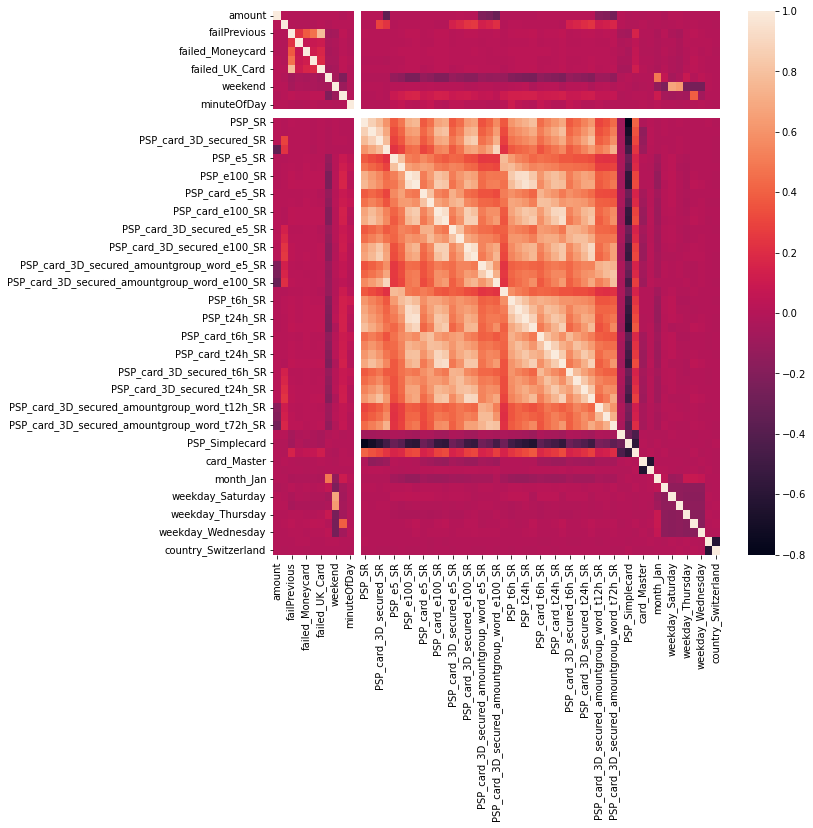

=== Highly correlated variables to drop ===
['PSP_card_e10_SR', 'PSP_card_e100_SR', 'PSP_card_t72h_SR', 'PSP_card_3D_secured_SR', 'PSP_card_3D_secured_t24h_SR', 'PSP_t6h_SR', 'PSP_card_3D_secured_amountgroup_word_e100_SR', 'PSP_card_3D_secured_e200_SR', 'PSP_card_t6h_SR', 'PSP_e5_SR', 'PSP_card_3D_secured_amountgroup_word_t24h_SR', 'PSP_t24h_SR', 'PSP_card_t24h_SR', 'PSP_card_3D_secured_e10_SR', 'PSP_card_SR', 'PSP_card_t12h_SR', 'PSP_card_3D_secured_amountgroup_word_e10_SR', 'PSP_SR', 'PSP_e100_SR', 'failPrevious', 'PSP_t12h_SR', 'PSP_e10_SR', 'PSP_card_3D_secured_e100_SR', 'PSP_e200_SR', 'PSP_card_3D_secured_t72h_SR', 'PSP_t72h_SR', 'PSP_card_e200_SR', 'PSP_card_3D_secured_amountgroup_word_e5_SR', 'PSP_card_3D_secured_t12h_SR']
=== Columns after removal ===
['amount', '3D_secured', 'failed_Goldcard', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'holiday', 'minuteOfDay', 'overallSR', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_e5_SR', 'P

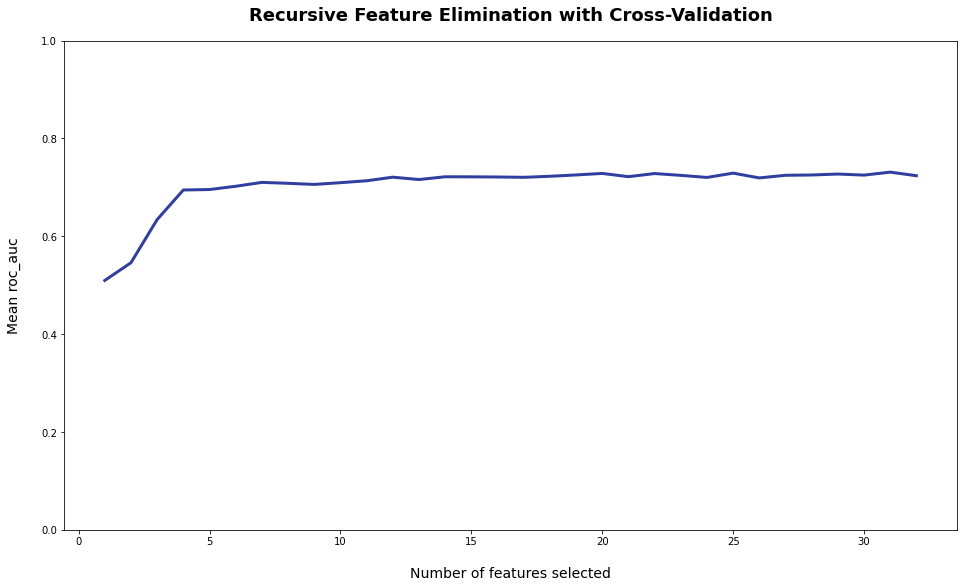

= Features:
['amount', '3D_secured', 'failed_Goldcard', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'holiday', 'minuteOfDay', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_e5_SR', 'PSP_card_3D_secured_e5_SR', 'PSP_t1h_SR', 'PSP_card_3D_secured_t6h_SR', 'PSP_card_3D_secured_amountgroup_word_t12h_SR', 'PSP_card_3D_secured_amountgroup_word_t72h_SR', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master', 'card_Visa', 'month_Jan', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'country_Germany', 'country_Switzerland']
= Maximum Test Score:
0.7310576928094003
=== Most important features ===
{'roc_auc': ['amount', '3D_secured', 'failed_Goldcard', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'holiday', 'minuteOfDay', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_e5_SR', 'PSP_card_3D_secured_e5_SR', 'PSP_t1h_SR', 'PSP_card_3D

In [22]:
rf_rfe, features_rf = fs.applyFeatureSelection(
    X_train, y_train, X_validate, y_validate, X_test, y_test,
    metrics = ["roc_auc"],
    estimator = rf_clf_basic,
    correlation_threshold = 0.75,
    step = 1,
    figsize = 10,
    write_model = False
)

#### Random Forest without correlation filtering

=== roc_auc ===
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting esti

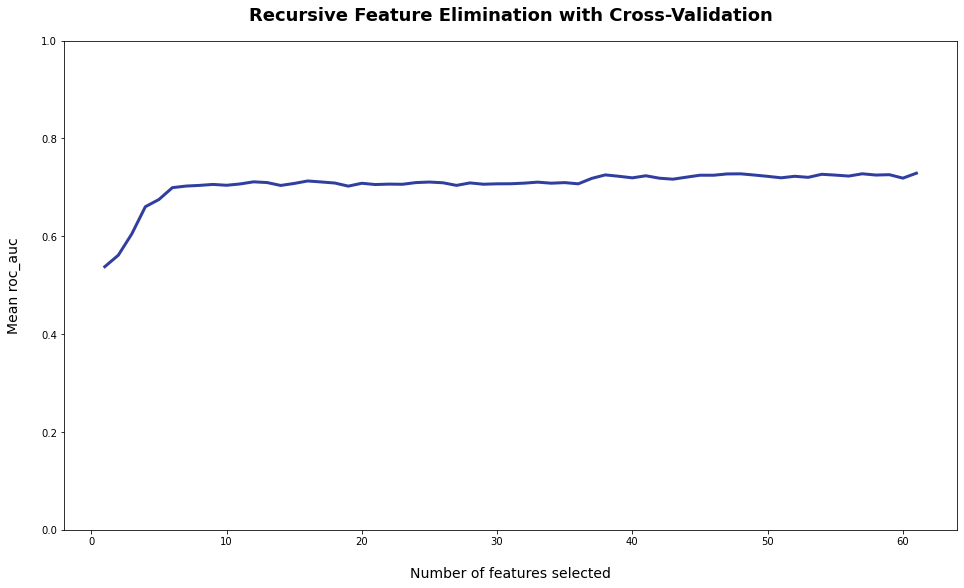

= Features:
['amount', '3D_secured', 'failPrevious', 'failed_Goldcard', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'holiday', 'minuteOfDay', 'overallSR', 'PSP_SR', 'PSP_card_SR', 'PSP_card_3D_secured_SR', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_e5_SR', 'PSP_e10_SR', 'PSP_e100_SR', 'PSP_e200_SR', 'PSP_card_e5_SR', 'PSP_card_e10_SR', 'PSP_card_e100_SR', 'PSP_card_e200_SR', 'PSP_card_3D_secured_e5_SR', 'PSP_card_3D_secured_e10_SR', 'PSP_card_3D_secured_e100_SR', 'PSP_card_3D_secured_e200_SR', 'PSP_card_3D_secured_amountgroup_word_e5_SR', 'PSP_card_3D_secured_amountgroup_word_e10_SR', 'PSP_card_3D_secured_amountgroup_word_e100_SR', 'PSP_t1h_SR', 'PSP_t6h_SR', 'PSP_t12h_SR', 'PSP_t24h_SR', 'PSP_t72h_SR', 'PSP_card_t6h_SR', 'PSP_card_t12h_SR', 'PSP_card_t24h_SR', 'PSP_card_t72h_SR', 'PSP_card_3D_secured_t6h_SR', 'PSP_card_3D_secured_t12h_SR', 'PSP_card_3D_secured_t24h_SR', 'PSP_card_3D_secured_t72h_SR', 'PSP_card_3D_secured_amountgroup_word_t1

In [23]:
rf_rfe_wo_corr, features_rf_wo_corr = fs.applyFeatureSelection(
    X_train, y_train, X_validate, y_validate, X_test, y_test,
    metrics = ["roc_auc"],
    estimator = rf_clf_basic,
    correlation_threshold = 0.75,
    step = 1,
    figsize = 10,
    write_model = False,
    correlation_filtering = False
)

#### Gradient Boosting with correlation filtering

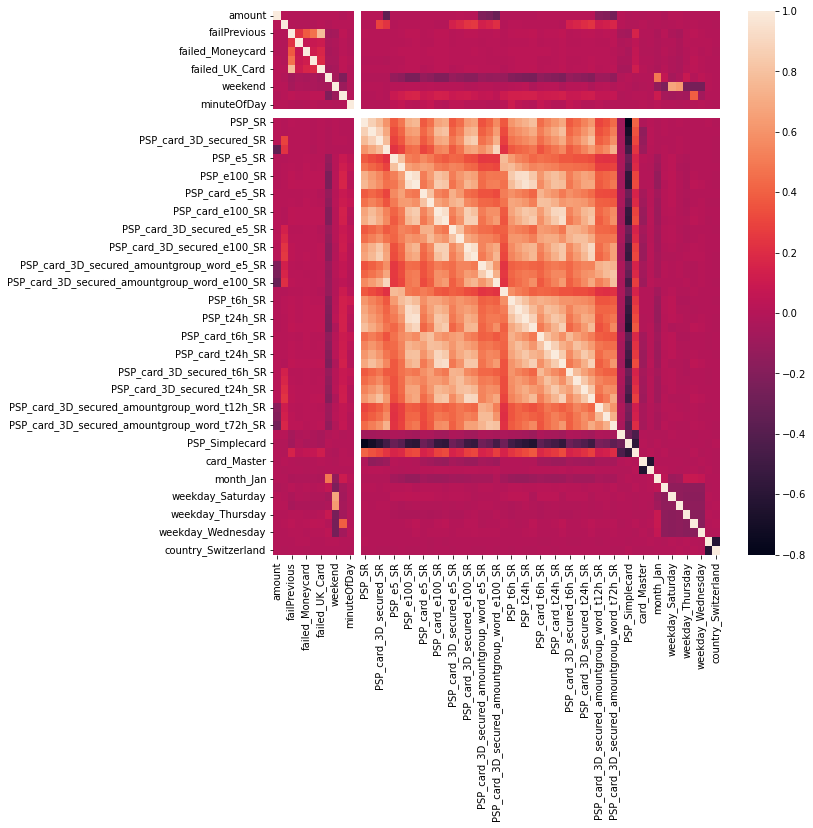

=== Highly correlated variables to drop ===
['PSP_card_e10_SR', 'PSP_card_e100_SR', 'PSP_card_t72h_SR', 'PSP_card_3D_secured_SR', 'PSP_card_3D_secured_t24h_SR', 'PSP_t6h_SR', 'PSP_card_3D_secured_amountgroup_word_e100_SR', 'PSP_card_3D_secured_e200_SR', 'PSP_card_t6h_SR', 'PSP_e5_SR', 'PSP_card_3D_secured_amountgroup_word_t24h_SR', 'PSP_t24h_SR', 'PSP_card_t24h_SR', 'PSP_card_3D_secured_e10_SR', 'PSP_card_SR', 'PSP_card_t12h_SR', 'PSP_card_3D_secured_amountgroup_word_e10_SR', 'PSP_SR', 'PSP_e100_SR', 'failPrevious', 'PSP_t12h_SR', 'PSP_e10_SR', 'PSP_card_3D_secured_e100_SR', 'PSP_e200_SR', 'PSP_card_3D_secured_t72h_SR', 'PSP_t72h_SR', 'PSP_card_e200_SR', 'PSP_card_3D_secured_amountgroup_word_e5_SR', 'PSP_card_3D_secured_t12h_SR']
=== Columns after removal ===
['amount', '3D_secured', 'failed_Goldcard', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'holiday', 'minuteOfDay', 'overallSR', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_e5_SR', 'P

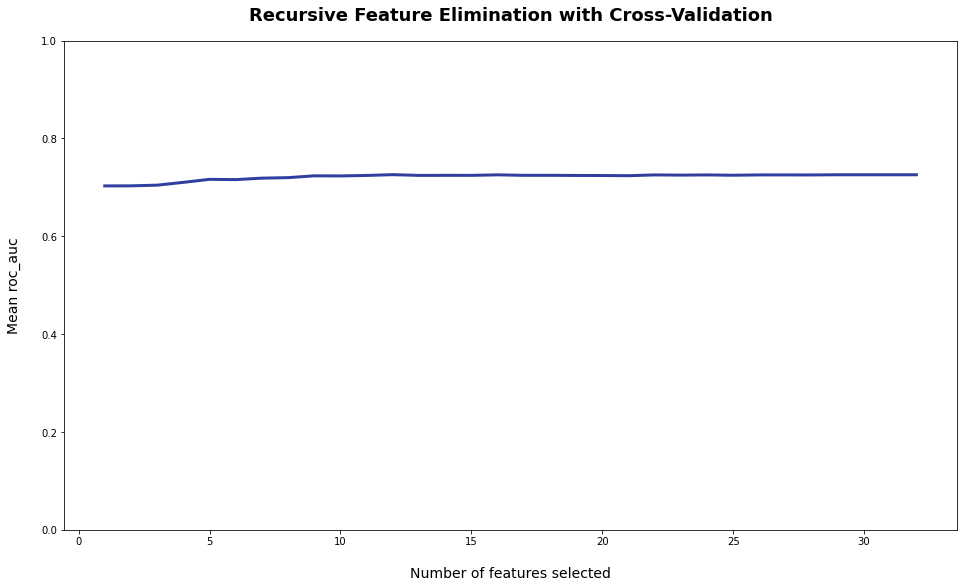

= Features:
['amount', '3D_secured', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_e5_SR', 'PSP_t1h_SR', 'PSP_card_3D_secured_t6h_SR', 'PSP_card_3D_secured_amountgroup_word_t72h_SR', 'PSP_Moneycard', 'PSP_UK_Card']
= Maximum Test Score:
0.7258981075172316
=== Most important features ===
{'roc_auc': ['amount', '3D_secured', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_e5_SR', 'PSP_t1h_SR', 'PSP_card_3D_secured_t6h_SR', 'PSP_card_3D_secured_amountgroup_word_t72h_SR', 'PSP_Moneycard', 'PSP_UK_Card']}


In [24]:
gbm_rfe, features_gbm = fs.applyFeatureSelection(
    X_train, y_train, X_validate, y_validate, X_test, y_test,
    metrics = ["roc_auc"],
    estimator = gbm_clf_basic,
    correlation_threshold = 0.75,
    step = 1,
    figsize = 10,
    write_model = False
)

#### Gradient Boosting without correlation filtering

=== roc_auc ===
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting esti

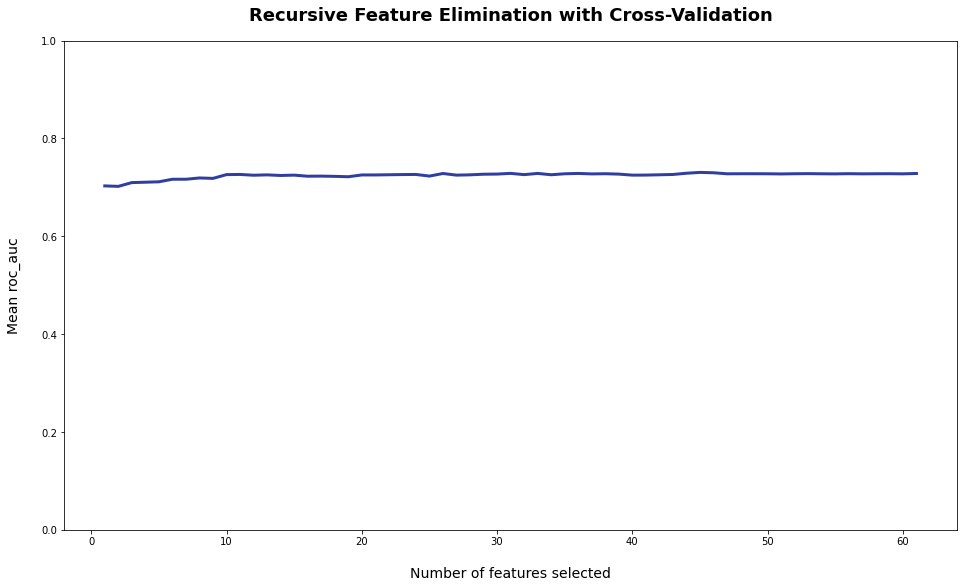

= Features:
['amount', 'failPrevious', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'PSP_SR', 'PSP_card_SR', 'PSP_card_3D_secured_SR', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_e5_SR', 'PSP_e10_SR', 'PSP_e100_SR', 'PSP_e200_SR', 'PSP_card_e5_SR', 'PSP_card_e10_SR', 'PSP_card_e100_SR', 'PSP_card_e200_SR', 'PSP_card_3D_secured_e5_SR', 'PSP_card_3D_secured_e10_SR', 'PSP_card_3D_secured_e100_SR', 'PSP_card_3D_secured_e200_SR', 'PSP_card_3D_secured_amountgroup_word_e5_SR', 'PSP_card_3D_secured_amountgroup_word_e10_SR', 'PSP_card_3D_secured_amountgroup_word_e100_SR', 'PSP_t1h_SR', 'PSP_t6h_SR', 'PSP_t12h_SR', 'PSP_t24h_SR', 'PSP_t72h_SR', 'PSP_card_t6h_SR', 'PSP_card_t12h_SR', 'PSP_card_t24h_SR', 'PSP_card_t72h_SR', 'PSP_card_3D_secured_t6h_SR', 'PSP_card_3D_secured_t12h_SR', 'PSP_card_3D_secured_t24h_SR', 'PSP_card_3D_secured_t72h_SR', 'PSP_card_3D_secured_amountgroup_word_t12h_SR', 'PSP_card_3D_secured_amountgroup_word_t24h_SR', 'PSP_card_3D

In [25]:
gbm_rfe_wo_corr, features_gbm_wo_corr = fs.applyFeatureSelection(
    X_train, y_train, X_validate, y_validate, X_test, y_test,
    metrics = ["roc_auc"],
    estimator = gbm_clf_basic,
    correlation_threshold = 0.75,
    step = 1,
    figsize = 10,
    write_model = False,
    correlation_filtering = False
)

#### XGBoost with correlation filtering

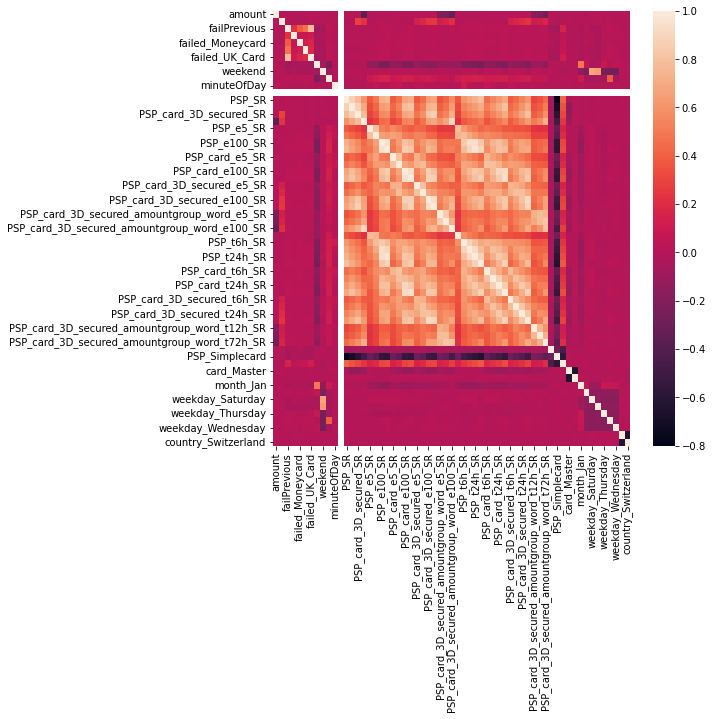

=== Highly correlated variables to drop ===
['PSP_card_e10_SR', 'PSP_card_e100_SR', 'PSP_card_t72h_SR', 'PSP_card_3D_secured_SR', 'PSP_card_3D_secured_t24h_SR', 'PSP_t6h_SR', 'PSP_card_3D_secured_amountgroup_word_e100_SR', 'PSP_card_3D_secured_e200_SR', 'PSP_card_t6h_SR', 'PSP_e5_SR', 'PSP_card_3D_secured_amountgroup_word_t24h_SR', 'PSP_t24h_SR', 'PSP_card_t24h_SR', 'PSP_card_3D_secured_e10_SR', 'PSP_card_SR', 'PSP_card_t12h_SR', 'PSP_card_3D_secured_amountgroup_word_e10_SR', 'PSP_SR', 'PSP_e100_SR', 'failPrevious', 'PSP_t12h_SR', 'PSP_e10_SR', 'PSP_card_3D_secured_e100_SR', 'PSP_e200_SR', 'PSP_card_3D_secured_t72h_SR', 'PSP_t72h_SR', 'PSP_card_e200_SR', 'PSP_card_3D_secured_amountgroup_word_e5_SR', 'PSP_card_3D_secured_t12h_SR']
=== Columns after removal ===
['amount', '3D_secured', 'failed_Goldcard', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'weekend', 'holiday', 'minuteOfDay', 'overallSR', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_e5_SR', 'P

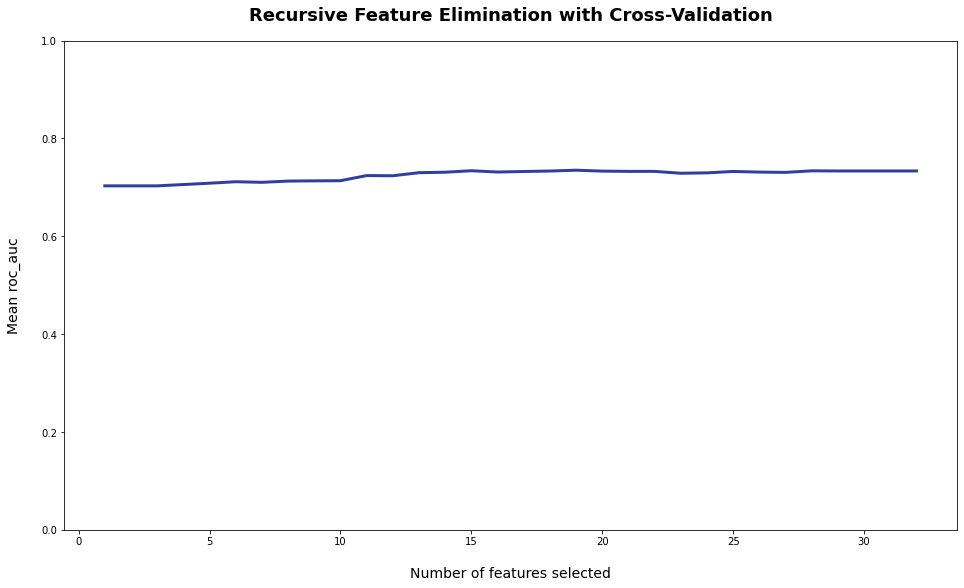

= Features:
['amount', '3D_secured', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_e5_SR', 'PSP_card_3D_secured_e5_SR', 'PSP_t1h_SR', 'PSP_card_3D_secured_t6h_SR', 'PSP_card_3D_secured_amountgroup_word_t12h_SR', 'PSP_card_3D_secured_amountgroup_word_t72h_SR', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master', 'card_Visa']
= Maximum Test Score:
0.7350051916745368
=== Most important features ===
{'roc_auc': ['amount', '3D_secured', 'failed_Moneycard', 'failed_Simplecard', 'failed_UK_Card', 'dayOfMonth', 'minuteOfDay', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_e5_SR', 'PSP_card_3D_secured_e5_SR', 'PSP_t1h_SR', 'PSP_card_3D_secured_t6h_SR', 'PSP_card_3D_secured_amountgroup_word_t12h_SR', 'PSP_card_3D_secured_amountgroup_word_t72h_SR', 'PSP_Moneycard', 'PSP_Simplecard', 'PSP_UK_Card', 'card_Master', 'card_Visa']}


In [36]:
xgb_rfe, features_xgb = fs.applyFeatureSelection(
    X_train, y_train, X_validate, y_validate, X_test, y_test,
    metrics = ["roc_auc"],
    estimator = xgb_clf_basic,
    correlation_threshold = 0.75,
    step = 1,
    figsize = 8,
    write_model = False
)

# features_xgb['roc_auc'] = fs.keepAllPSP(features_xgb['roc_auc'])

xgb_best_score_corr = fs.validate_classifier(xgb_rfe.estimator_, X_validate, y_validate, selected_features = features_xgb["roc_auc"])

#### XGBoost without correlation filtering

=== roc_auc ===
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting esti

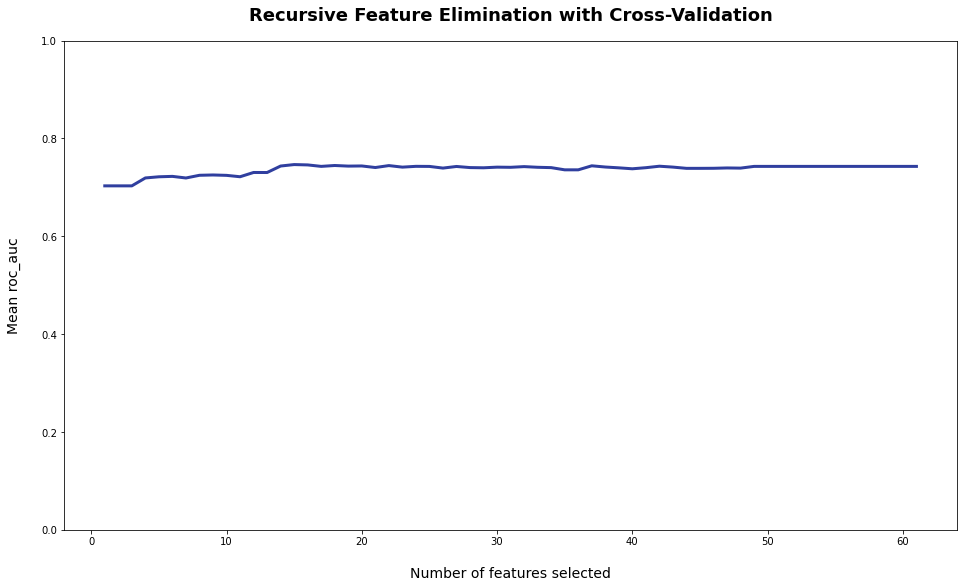

= Features:
['amount', '3D_secured', 'failPrevious', 'dayOfMonth', 'minuteOfDay', 'PSP_SR', 'PSP_card_SR', 'PSP_card_3D_secured_SR', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_3D_secured_e100_SR', 'PSP_t6h_SR', 'PSP_t12h_SR', 'PSP_Moneycard', 'PSP_UK_Card', 'card_Visa']
= Maximum Test Score:
0.746524578274277
=== Most important features ===
{'roc_auc': ['amount', '3D_secured', 'failPrevious', 'dayOfMonth', 'minuteOfDay', 'PSP_SR', 'PSP_card_SR', 'PSP_card_3D_secured_SR', 'PSP_card_3D_secured_amountgroup_word_SR', 'PSP_card_3D_secured_e100_SR', 'PSP_t6h_SR', 'PSP_t12h_SR', 'PSP_Moneycard', 'PSP_UK_Card', 'card_Visa']}


In [27]:
xgb_rfe_wo_corr, features_xgb_wo_corr = fs.applyFeatureSelection(
    X_train, y_train, X_validate, y_validate, X_test, y_test,
    metrics = ["roc_auc"],
    estimator = xgb_clf_basic,
    correlation_threshold = 0.75,
    step = 1,
    figsize = 10,
    write_model = False,
    correlation_filtering = False
)

xgb_best_score_wo_corr = fs.validate_classifier(xgb_rfe_wo_corr.estimator_, X_validate, y_validate, selected_features = features_xgb_wo_corr["roc_auc"])

**Conclusion**: The feature selection process and the achieved performance score on validation data shows, that the XGBoost classifier outperforms the other tree ensembles. This holds for the performance as well as the number of features needed.

### Hyperparameter Optimization

#### XGBoost

In [28]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from sklearn.model_selection import cross_val_score

if xgb_best_score_wo_corr > xgb_best_score_corr:
    print("=== Take features from experiment without correlation filtering ===")
    features_xgb = features_xgb_wo_corr
    # features_xgb['roc_auc'] = fs.keepAllPSP(features_xgb['roc_auc'])

X_tune, y_tune, cv_tune = generateCV(X_train, y_train, X_validate, y_validate)
X_tune = X_tune[features_xgb['roc_auc']]

space = [
    Integer(3, 18, name = 'max_depth'),
    Real(1, 9, name = 'gamma'),
    Integer(0, 100, name = 'reg_alpha'),
    Integer(0, 100, name = 'reg_lambda'),
    Integer(0, 10, name = 'min_child_weight'),
    Integer(5, 1000, name = 'n_estimators'),
    Real(0.001, 0.3, name = 'learning_rate'),
    Real(0.5, 1, name = 'subsample'),
    Real(0.4, 1, name = 'colsample_bytree'),
    Real(0.4, 1, name = 'colsample_bylevel')
]

def objective(params):
    model = xgb.XGBClassifier(
        max_depth = params[0],
        gamma = params[1],
        reg_alpha = params[2],
        reg_lambda = params[3],
        min_child_weight = params[4],
        n_estimators = params[5],
        learning_rate = params[6],
        subsample = params[7],
        colsample_bytree = params[8],
        colsample_bylevel = params[9],
        n_jobs = -1
    )
    
    score = cross_val_score(model, X_tune, y_tune, cv = cv_tune, n_jobs = -1, scoring = 'roc_auc').mean()
    
    return -score

result = gp_minimize(objective, space, n_calls=50, random_state = 1977, verbose = 1)

xgb_clf_tuned = xgb.XGBClassifier(
        max_depth = result.x[0],
        gamma = result.x[1],
        reg_alpha = result.x[2],
        reg_lambda = result.x[3],
        min_child_weight = result.x[4],
        n_estimators = result.x[5],
        learning_rate = result.x[6],
        subsample = result.x[7],
        colsample_bytree = result.x[8],
        colsample_bylevel = result.x[9],
        eval_metric="auc",
        early_stopping_rounds=10,
        n_jobs = -1,
        random_state = 1977
    ).fit(X_train[features_xgb['roc_auc']], y_train, eval_set=[(X_validate[features_xgb['roc_auc']], y_validate)])

print("======================================")
# print(f"Best score: {-result.fun}")
print("Best hyperparameters: ", dict(zip(['max_depth', 'gamma', 
                                          'reg_alpha', 'reg_lambda', 'min_child_weight', 
                                          'n_estimators', 'learning_rate', 'subsample', 
                                          'colsample_bytree', 'colsample_bylevel'], result.x)))

modelParams = hf.loadPickle('./data/parameters.pkl')
modelParams["finalParams"] = {}
keys = ['max_depth', 'gamma', 'reg_alpha', 'reg_lambda', 'min_child_weight', 'n_estimators', 
        'learning_rate', 'subsample', 'colsample_bytree', 'colsample_bylevel']
for i in range(len(keys)):
    modelParams["finalParams"][keys[i]] = result.x[i]
modelParams["features"] = features_xgb['roc_auc']
hf.writePickle('./data/parameters.pkl', modelParams)

print("= Validation results for tuned classifier:")
validate_classifier(xgb_clf_tuned, X_validate[features_xgb['roc_auc']], y_validate, selected_features = features_xgb['roc_auc'])
print("======================================")

=== Take features from experiment without correlation filtering ===
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.3166
Function value obtained: -0.7088
Current minimum: -0.7088
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.8239
Function value obtained: -0.7091
Current minimum: -0.7091
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.0623
Function value obtained: -0.7436
Current minimum: -0.7436
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.2551
Function value obtained: -0.7141
Current minimum: -0.7436
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.8903
Function value 

Hyperparametertuning and Feature selection increased the performance on validation data of the model and reduced the complexity considerably by reducing the number of used features from 61 to just 15, which also increases the interpretability of the prediction results, which will be addressed in the next step.

**Conclusion**: The added value of hyperparameter tuning is not very high if sticking to good heuristic hyperparameter approaches in the model exploration phase. The final model decision will be done based on the model performance on test data.

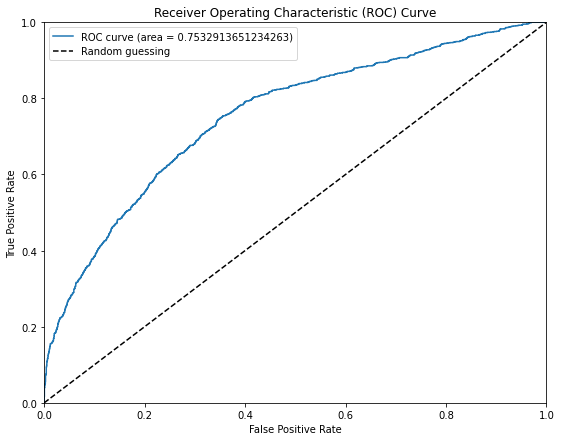

In [29]:
y_probabilities = xgb_clf_tuned.predict_proba(X_validate[features_xgb['roc_auc']])[:, 1]

fpr, tpr, thresholds = roc_curve(y_validate, y_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 7))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc})")
plt.plot([0, 1], [0, 1], 'k--', label="Random guessing")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

## Assessing the Model
### Calibrate the classifier

Tree based models are only able to predict probability-like scores and does therefore not produce probabilities by default. Therefore the scores of the XGBoost classifier have to be calibrated, such that they can be interpreted as probabilities. This is essential because the complete intuition of the defined approach for this case study is based on probabilities. The first step is to visualize how far off the model scores are from a perfectly calibrated classifier. This is done by a so called calibration curve.

In [30]:
xgb_probabilities = list(xgb_clf_tuned.predict_proba(X_validate[features_xgb['roc_auc']])[:, 1])
xgb_y, xgb_x = calibration_curve(y_validate, xgb_probabilities, n_bins = 10)

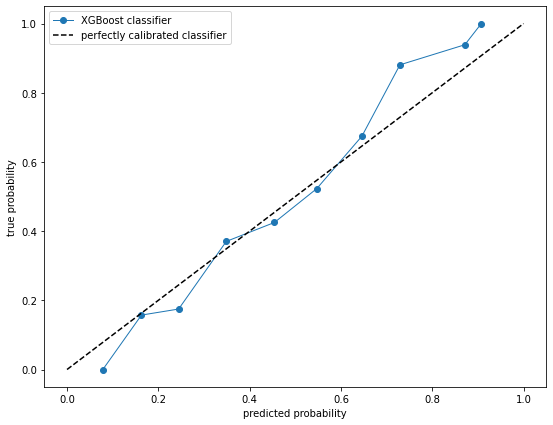

In [31]:
plt.figure(figsize=(9, 7))
plt.plot(xgb_x, xgb_y, marker = 'o', linewidth = 1, label = 'XGBoost classifier')
plt.plot([0, 1], [0, 1], 'k--', label = 'perfectly calibrated classifier')
plt.xlabel('predicted probability')
plt.ylabel('true probability')
plt.legend()
plt.show()

From the plot it can be concluded, that the trained classifier underestimates the true probability for predicted scores greater than 0.55 and works as expected for scores lower than that. The underestimation for the higher scores is linear, therefore it is not necessarily indicated to calibrate the classifier. The final decision will be made by comparing the calibrated model with the final XGBoost classifier. Therefore the next step is to calibrate the classifier in order to make the predicted scores match the true likelihood. The two main techniques are Platt scaling and isotonic regression. Whereas Platt scaling relies on a sigmoid logistic regression model, isotonic regression fits a non-parametric isotonic regressor on the data. In general the isotonic approach will perform as well as or better than the Platt approach, given enough data (Niculescu-Mizil & Caruana, 2005). Hence an isotonic regression is used to calibrate the XGBoost classifier.

In [32]:
xgb_tuned_classifier = xgb.XGBClassifier(
        max_depth = result.x[0],
        gamma = result.x[1],
        reg_alpha = result.x[2],
        reg_lambda = result.x[3],
        min_child_weight = result.x[4],
        n_estimators = result.x[5],
        learning_rate = result.x[6],
        subsample = result.x[7],
        colsample_bytree = result.x[8],
        colsample_bylevel = result.x[9],
        n_jobs = -1,
        random_state = 1977
    )

calibrated_xgb_clf = CalibratedClassifierCV(xgb_tuned_classifier, cv=cv_tune).fit(X_tune, y_tune)

In [33]:
validate_classifier(calibrated_xgb_clf, X_test, y_test, selected_features = features_xgb['roc_auc'])

=== Validation ROC AUC ===
0.7642084640312429
=== Validation Precision ===
0.6498388829215896
=== Validation Recall ===
0.41552197802197804
=== Validation Accuracy ===
0.7129968300414533


In [34]:
validate_classifier(xgb_clf_tuned, X_test, y_test, selected_features = features_xgb['roc_auc'])

=== Validation ROC AUC ===
0.765055230686138
=== Validation Precision ===
0.6378326996197718
=== Validation Recall ===
0.4608516483516483
=== Validation Accuracy ===
0.7156791026578884


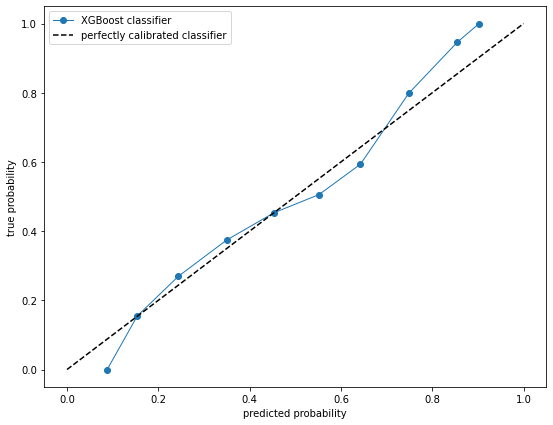

In [35]:
xgb_probabilities = list(calibrated_xgb_clf.predict_proba(X_validate[features_xgb['roc_auc']])[:, 1])
xgb_y, xgb_x = calibration_curve(y_validate, xgb_probabilities, n_bins = 10)

plt.figure(figsize=(9, 7))
plt.plot(xgb_x, xgb_y, marker = 'o', linewidth = 1, label = 'XGBoost classifier')
plt.plot([0, 1], [0, 1], 'k--', label = 'perfectly calibrated classifier')
plt.xlabel('predicted probability')
plt.ylabel('true probability')
plt.legend()
plt.show()

**Conclusion**: Overall the model calibration decreases the performance of the classifier and is also not able to completely remove the underestimation of the true probability for high predicted scores. Hence, the final XGBoost classifier trained after hyperparameter tuning will be retained.

## References

<p>Arlot, S., & Celisse, A. (2010). A survey of cross-validation procedures for model selection. Statistics Surveys, 4(none). https://doi.org/10.1214/09-SS054</p>
<p>Athanasopoulos, G., & Hyndman, R. J. (2021). Forecasting: Principles and Practice (3. Aufl.). OTexts. OTexts.com/fpp3</p>
<p>Bygari, R., Gupta, A., Raghuvanshi, S., Bapna, A., & Sahu, B. (2021). An AI-powered Smart Routing Solution for Payment Systems. 2026–2033. https://doi.org/10.1109/BigData52589.2021.9671961</p>
<p>Chetcuti, J. (2020). PhiCor: Calculating Phi coefficient of Association. (edsbas.C61D16BC). BASE. https://doi.org/10.5281/zenodo.3898308
IBM Corporation. (2021). IBM Documentation: IBM SPSS Modeler CRISP-DM Guide. https://www.ibm.com/docs/en/spss-modeler/18.1.1?topic=spss-modeler-crisp-dm-guide</p>
<p>Kornbrot, D. (2005). Point Biserial Correlation. https://doi.org/10.1002/0470013192.bsa485</p>
<p>Kuhn, M., & Johnson, K. (2013). Applied Predictive Modeling (1st ed. 2013, Corr. 2nd printing 2018 Edition). Springer.</p>
<p>Kuhn, M., & Johnson, K. (2019). Feature Engineering and Selection: A Practical Approach for Predictive Models. Taylor & Francis Ltd. http://www.feat.engineering/</p>
<p>Lakshmanan, V., Robinson, S., & Munn, M. (2020). Machine Learning Design Patterns: Solutions to Common Challenges in Data Preparation, Model Building, and MLOps. O’Reilly Media.</p>
<p>Leonard, M., & Wolfe, B. (2005). Mining transactional and time series data. abstract, presentation and paper, SUGI, 10–13.</p>
<p>Mao, X., Xu, S., Kumar, R., R, V., Hong, X., & Menghani, D. (2023). Improving the customer’s experience via ML-driven payment routing. https://engineering.linkedin.com/blog/2023/improving-the-customer-s-experience-via-ml-driven-payment-routin</p>
<p>Mu, L. (2021). Using Machine Learning to Improve Payment Authorization Rate | The PayPal Technology Blog. https://medium.com/paypal-tech/using-machine-learning-to-improve-payment-authorization-rates-bc3b2cbf4999</p>
<p>Wirth, R., & Hipp, J. (2000). CRISP-DM: Towards a standard process model for data mining. Proceedings of the 4th International Conference on the Practical Applications of Knowledge Discovery and Data Mining.</p>